# Predicting Game Outcomes in League of Legends Using a Neural Network
This project explores the use of a neural network to predict game outcomes (win/loss) in **Ranked Solo/Duo** matches of *League of Legends* based on in-game performance metrics and final stats.

We begin with a carefully filtered and cleaned dataset, excluding metadata and focusing solely on gameplay-relevant features. After an initial baseline model, we implement 5-fold cross-validation and apply **GridSearchCV** to explore optimal hyperparameter configurations (neurons, dropout rate, learning rate) in pursuit of better performance.

Throughout the notebook, we focus on:
- Clean and consistent preprocessing
- One-hot encoding of categorical features
- Standardization of input features
- Thoughtful regularization (dropout and early stopping)
- Robust cross-validation and hyperparameter tuning

In [2]:
#core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#data preprocessing and modeling tools
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SklearnPipeline

#deep learning (Keras + TensorFlow backend)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#scikit-learn wrapper for Keras
from scikeras.wrappers import KerasClassifier

#model evaluation
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

#saving model
import joblib

In [3]:
#load dataset
df_csv = pd.read_csv("league_data.csv", dtype={'win': str})

#define columns to remove (metadata, identifiers, ranking tiers, non-gameplay details)
columns_to_drop = [
    'game_id', 'game_version', 'participant_id', 'puuid', 'summoner_name', 'summoner_id',
    'solo_tier', 'solo_rank', 'solo_lp', 'solo_wins', 'solo_losses',
    'flex_tier', 'flex_rank', 'flex_lp', 'flex_wins', 'flex_losses',
    'champion_mastery_lastPlayTime', 'champion_mastery_lastPlayTime_utc',
    'champion_id', 'map_id', 'platform_id', 'game_type', 'team_id',
    'game_start_utc', 'queue_id', 'game_mode'
]

#filter for Ranked Solo/Duo games in CLASSIC mode
df_filtered = df_csv[(df_csv['game_mode'] == 'CLASSIC') & (df_csv['queue_id'] == 420)].copy()

#drop unnecessary columns
df_filtered_cleaned = df_filtered.drop(columns=[col for col in columns_to_drop if col in df_filtered.columns])

#convert 'win' column to binary (1 for win, 0 for loss)
df_filtered_cleaned['win'] = (df_filtered['win'] == 'TRUE').astype(int)

#rename
df = df_filtered_cleaned.copy()

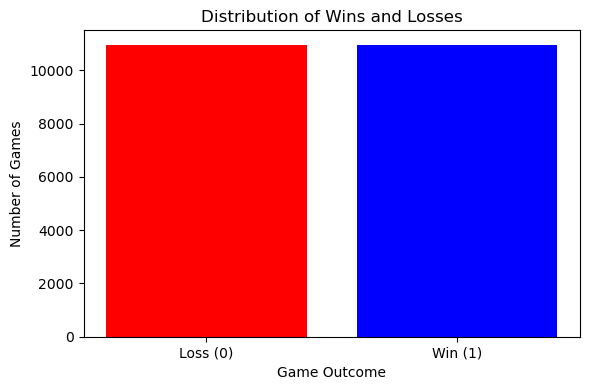

In [4]:
#Win Distribution Analysis
win_counts = df['win'].value_counts().sort_index()  # ensures 0 (loss) comes before 1 (win)

# Plot with custom colors and labels
plt.figure(figsize=(6, 4))
plt.bar(['Loss (0)', 'Win (1)'], win_counts.values, color=['red', 'blue'])
plt.xlabel('Game Outcome')
plt.ylabel('Number of Games')
plt.title('Distribution of Wins and Losses')
plt.tight_layout()
plt.show()

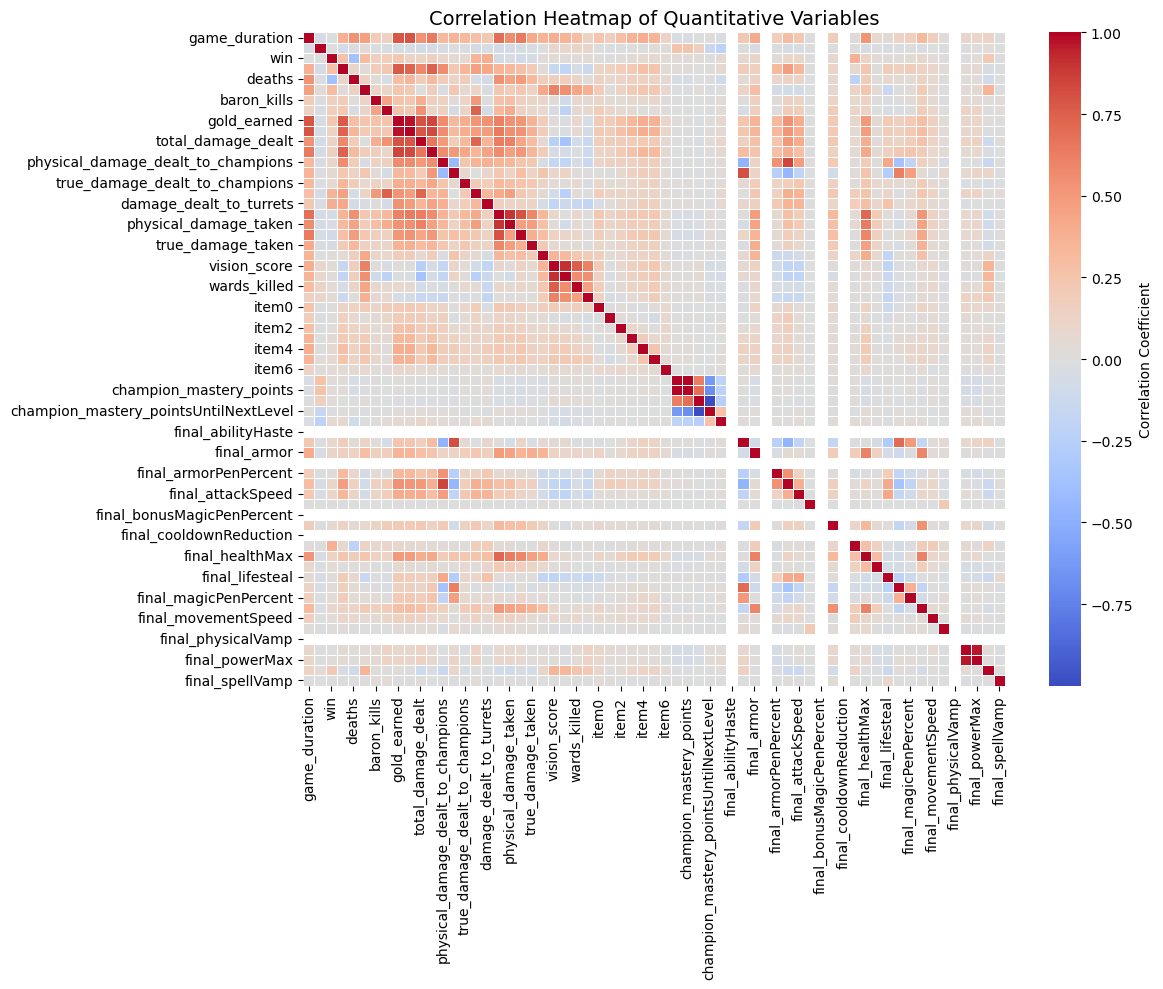

In [5]:
#Heat Map for Quantitative Variables
#select only numeric features
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    cmap='coolwarm',          #or 'viridis', 'magma', 'YlGnBu', etc.
    annot=False,              #set to True if you want the correlation values displayed (for smaller heat maps)
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title("Correlation Heatmap of Quantitative Variables", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
#for now, we will retain highly correlated variables to see how the model performs

In [6]:
#separate predictors (X) and labels (y)
X = df.drop(columns=['win'], errors='ignore')
y = df['win']

In [7]:
#convert categorical variables into dummy/one-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)

In [8]:
#split data into training+validation set (80%) and future holdout test set (20%), stratify ensures two classes are balanced across splits
X_train, X_val, y_train, y_val = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y
)

In [9]:
#check class distribution (percentage of wins/losses) across all splits (ensures unbiased training and evaluation)
train_dist = y_train.value_counts(normalize=True)
val_dist = y_val.value_counts(normalize=True)

#combine distributions into a summary table
strat_check_df = pd.DataFrame({
    'Train': train_dist,
    'Validation': val_dist
}).T

#display the summary
strat_check_df

win,1,0
Train,0.5,0.5
Validation,0.5,0.5


In [10]:
#normalize predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Baseline Neural Network Model

We defind a baseline neural network architecture to serve as a reference point. The model consists of two hidden layers with ReLU activation and dropout for regularization. It is compiled with the Adam optimizer and binary cross-entropy loss for binary classification.

This baseline will be evaluated using 5-fold cross-validation before proceeding to hyperparameter tuning.

In [12]:
#define a function to create our neural network model
#architecture: input → dense(64) → dropout(0.3) → dense(32) → dropout(0.2) → output
def create_model():
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),  #input layer matching number of features
        Dense(64, activation='relu'),             #first hidden layer with ReLU
        Dropout(0.3),                              #drop 30% of neurons to prevent overfitting
        Dense(32, activation='relu'),             #second hidden layer
        Dropout(0.2),                              #drop 20%
        Dense(1, activation='sigmoid')            #output layer: binary classification
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

#wrap the model in a KerasClassifier for compatibility with scikit-learn
model_wrapper = KerasClassifier(
    build_fn=create_model,  #callable to build the model (lets GridSearchCV pass parameters)
    epochs=50,             #number of training epochs (might get stopped early)
    batch_size=32,          #batch size: samples seen before weight update, 32 is a common default
    verbose=0               #silent training
)

In [13]:
#define the earlystopping callback for cross-validation to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', #monitors validation loss
    patience=10, #checks for 10 epochs of no improvement, training stops if so
    restore_best_weights=True #restores best weights after 10 epochs of no improvement
)

Fold accuracy: 0.49
Fold accuracy: 0.49
Fold accuracy: 0.51
Fold accuracy: 0.49
Fold accuracy: 0.49
Mean CV Accuracy: 0.49


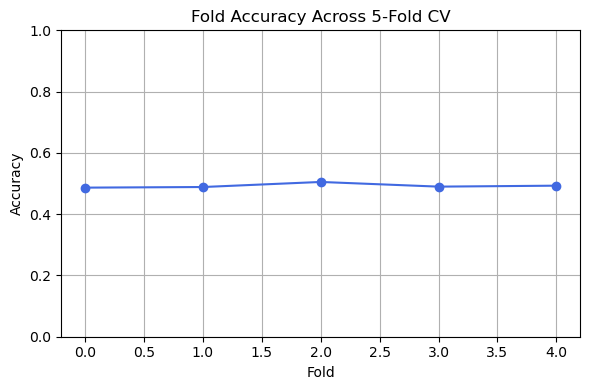

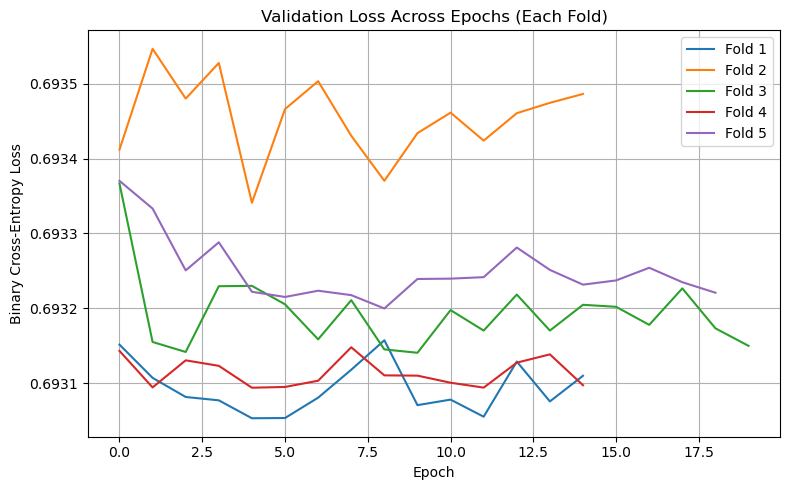

In [14]:
#set up 5-fold cross validation on the training set
kf = KFold(n_splits=5, shuffle=True)
cv_scores = []
history_list = [] #dictonary for saving loss histories

for train_index, test_index in kf.split(X_train_scaled):
    #splits current fold into training and testing portions
    X_cv_train, X_cv_test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_cv_train, y_cv_test = np.array(y_train)[train_index], np.array(y_train)[test_index]
    
    #create a new instance of the model (weights reset each time)
    model = create_model()
    
    #train the model with early stopping and validation split (e.g., 20% of the current fold used for validation)
    history = model.fit(
        X_cv_train, 
        y_cv_train, 
        epochs=50, 
        batch_size=32, 
        verbose=0, 
        validation_split=0.2, 
        callbacks=[early_stopping]
    )
    
    #evaluate the model on the current fold's test set
    score = model.evaluate(X_cv_test, y_cv_test, verbose=0)
    cv_scores.append(score[1])
    history_list.append(history)
    print(f"Fold accuracy: {score[1]:.2f}")

#report average cross-validated accuracy
print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")

#plot cv scores
plt.figure(figsize=(6, 4))
plt.plot(cv_scores, marker='o', linestyle='-', color='royalblue')
plt.title('Fold Accuracy Across 5-Fold CV')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

#plot validation loss per fold
plt.figure(figsize=(8, 5))
for i, history in enumerate(history_list):
    val_loss = history.history['val_loss']
    plt.plot(val_loss, label=f'Fold {i+1}')
    
plt.title('Validation Loss Across Epochs (Each Fold)')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Hyperparameter Tuning with Grid Search

To improve model performance, we perform a grid search over key neural network hyperparameters — including the number of neurons, dropout rate, and learning rate — using cross-validation to identify the best configuration.


In [16]:
#We define a flexible model architecture with tunable hyperparameters for neurons, dropout rate, and learning rate. 
#This allows us to explore optimal configurations via GridSearchCV.

def create_model(neurons=64, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(neurons, activation='relu'),
        Dropout(dropout_rate),
        Dense(int(neurons / 2), activation='relu'),
        Dropout(dropout_rate / 2),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Scikit-Learn Pipeline for Preprocessing and Model Wrapping

We define a streamlined pipeline that standardizes the input features before feeding them into a neural network. Missing values are imputed beforehand to avoid any data leakage during cross-validation.

The neural network is wrapped using `KerasClassifier` to integrate with scikit-learn’s API, allowing the use of `GridSearchCV` for hyperparameter tuning within a clean and modular pipeline.

In [18]:
#impute X_train before passing it to the pipeline (pipeline still handles internal CV splits)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

In [19]:
#preprocessing pipeline: Impute missing values, then scale, no data leakage because this is applied only within the pipeline
preprocessor = SklearnPipeline([
    ('scaler', StandardScaler())
])

#define the model wrapper WITH default values for batch_size and epochs
model_wrapper = KerasClassifier(
    model=create_model,
    batch_size=32,    # set here, not in param_grid
    epochs=50,        # set here too
    verbose=0
)

#combine preprocessing and model training into one clean pipeline
full_pipeline = SklearnPipeline([
    ('preprocessing', preprocessor),
    ('nn', model_wrapper)
])

# Grid Search for Hyperparameter Tuning

We perform a grid search across key hyperparameters in the neural network architecture, using 3-fold cross-validation to select the combination that yields the highest mean validation accuracy.


In [21]:
#define the grid of hyperparameters to search over
param_grid = {
    'nn__model__neurons': [64, 128],
    'nn__model__dropout_rate': [0.3, 0.4],
    'nn__model__learning_rate': [0.001]  #can change later if needed
}

#set up GridSearchCV with 3-fold cross-validation
grid = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    error_score = 'raise' #this reveals the truth
)

#fit grid search on the imputed training data
grid_result = grid.fit(X_train_imputed, y_train)

#display best results
print("Best CV Accuracy: {:.2f}% using {}".format(
    grid_result.best_score_ * 100, grid_result.best_params_
))

Best CV Accuracy: 88.42% using {'nn__model__dropout_rate': 0.4, 'nn__model__learning_rate': 0.001, 'nn__model__neurons': 64}


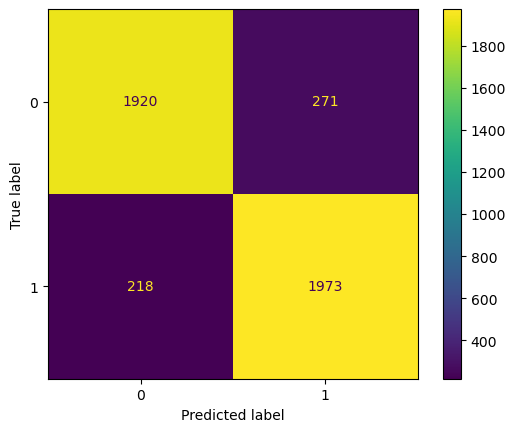

In [22]:
#confusion matrix
#impute X_val
X_val_imputed = imputer.transform(X_val)

#predict using the best estimator
y_val_pred = grid.best_estimator_.predict(X_val_imputed)

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)


# Final Model Definition with Best Hyperparameters

Based on the results of GridSearchCV, we define the final version of the neural network using the best-performing hyperparameters:
- 64 neurons in the first hidden layer
- 40% dropout
- Learning rate of 0.001

This model will now be retrained on the full training set and evaluated on the validation set.

In [24]:
#final model definition using best-found hyperparameters from GridSearchCV
def create_model(neurons=64, dropout_rate=0.4, learning_rate=0.001):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),     #input layer: matches number of features
        Dense(neurons, activation='relu'),    #first hidden layer
        Dropout(dropout_rate),                #regularization
        Dense(int(neurons / 2), activation='relu'),  #second hidden layer
        Dropout(dropout_rate / 2),            #slightly reduced dropout
        Dense(1, activation='sigmoid')        #output: probability of win (binary classification)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Final Model Training

Using the best hyperparameters discovered through GridSearchCV, we now train the final version of the neural network on the full training dataset. The preprocessing pipeline includes only feature scaling, as missing values have already been imputed prior to this step.


In [26]:
#final preprocessing
preprocessor = SklearnPipeline([
    ('scaler', StandardScaler())
])

#model wrapper with best hyperparameters
model_wrapper = KerasClassifier(
    model=create_model,     #uses final architecture with tuned parameters
    batch_size=32,
    epochs=50,
    verbose=0
)

#full pipeline: preprocessing + final model
final_pipeline = SklearnPipeline([
    ('preprocessing', preprocessor),
    ('nn', model_wrapper)
])

#train the final model on all training data
final_pipeline.fit(X_train_imputed, y_train)


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('scaler', StandardScaler())])),
                ('nn',
                 KerasClassifier(batch_size=32, epochs=50, model=<function create_model at 0x000001EC266F5940>, verbose=0))])

# Final Model Evaluation on Validation Set

After training the final model, we evaluate its performance on the holdout validation set using accuracy, F1 score, ROC AUC, and a confusion matrix. This confirms whether the model maintains its performance outside of cross-validation.


Final Model Validation Accuracy: 0.89
Final Model F1 Score: 0.89
Final Model ROC AUC: 0.89

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2191
           1       0.88      0.90      0.89      2191

    accuracy                           0.89      4382
   macro avg       0.89      0.89      0.89      4382
weighted avg       0.89      0.89      0.89      4382



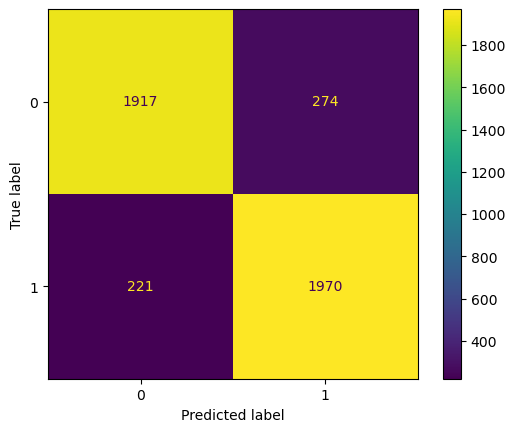

In [28]:
#transform validation data using the same preprocessing flow
X_val_scaled = preprocessor.fit_transform(X_val_imputed)

#predict on validation set
y_val_pred = final_pipeline.predict(X_val_imputed)

#evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_pred)

#display results
print(f"Final Model Validation Accuracy: {accuracy:.2f}")
print(f"Final Model F1 Score: {f1:.2f}")
print(f"Final Model ROC AUC: {roc_auc:.2f}")
print("\nClassification Report:\n")
print(classification_report(y_val, y_val_pred))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)

In [29]:
#save the final pipeline and model to disk
import joblib

joblib.dump(final_pipeline, "final_league_nn_pipeline.pkl")
print("Final model saved as 'final_league_nn_pipeline.pkl'")

Final model saved as 'final_league_nn_pipeline.pkl'


# Conclusion

This notebook presents a complete neural network modeling workflow to predict match outcomes in **Ranked Solo/Duo League of Legends games**.

Starting with a clean and focused dataset, we:
- Removed metadata and redundant identifiers
- Imputed missing values and applied standardization
- Encoded categorical variables appropriately
- Built a baseline neural network model
- Performed **GridSearchCV** with cross-validation to find the best hyperparameters
- Trained and evaluated the final model on a separate validation set

The final model achieved **89% accuracy**, **89% F1 score**, and **89% ROC AUC**, demonstrating excellent balance between precision and recall, and strong generalization.

This project not only showcases neural network implementation in Python using scikit-learn and Keras, but also highlights best practices in model validation, preprocessing pipelines, and reproducibility.

---

Model saved to: `final_league_nn_pipeline.pkl` 
Thank you for reading.